In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Akima1DInterpolator
from scipy.signal.windows import tukey
from scipy.signal import hilbert

from time import time
from timuscle.dataio import verasonics_loadtrackrf, putdictasHDF5

In [2]:
with open("cupy_module.cu", mode='r') as fp: raw_module = fp.read()

module = cp.RawModule(code=raw_module)

das_bmode_cubic = module.get_function("das_bmode_cubic")

xInfo = np.dtype([('x0', np.float32),('dx', np.float32),('nx', np.int32)])
RFInfo = np.dtype([('ntx', np.int32),('nrx', np.int32),('ndim', np.int32),('tInfo', xInfo)])

In [48]:
datapath = "/fastrs/ultrasound/TIMuscle/InVivo/20230421_V001/acq_1_flex_90_musc_vl/RawData/"

rf, dims, rfpar = verasonics_loadtrackrf(datapath)

print(rf.shape, dims['steer_deg'])

xele = dims['xele_m']
steers = dims['steer_deg']
t = dims['t_sec']

(36, 128, 89, 3, 1536) [-3.  0.  3.]


In [49]:
c0 = 1540
r0 = 10

origtx = cp.ascontiguousarray(cp.array([[xele[-1] if steer <= 0 else xele[0] for steer in steers], np.zeros(steers.shape)], dtype=np.float32).T, dtype=cp.float32)

# calculate point source location to approximate plane waves
ovectx = cp.ascontiguousarray(-r0 * cp.array([np.sin(np.radians(steers)), np.cos(np.radians(steers))]).T, dtype=np.float32)

# calculate normal vector of point source
nvectx = cp.ascontiguousarray(cp.array([np.sin(np.radians(steers)), np.cos(np.radians(steers))]).T, dtype=np.float32)

t0tx = -cp.linalg.norm(origtx - ovectx, axis=-1)/c0

dof = cp.zeros(len(t0tx), dtype=np.float32)

# calculate acceptance angle for plane wave source approximated as a point
dxo = origtx - ovectx
alatx = cp.arccos(cp.abs(cp.sum(dxo * nvectx, axis=-1)) / cp.linalg.norm(dxo, axis=-1))

print(t0tx.dtype)

ovecrx = cp.ascontiguousarray(cp.array([xele, np.zeros(len(xele))]).T, dtype=np.float32)
nvecrx = cp.ascontiguousarray(cp.array([np.zeros(len(xele)), np.ones(len(xele))]).T, dtype=np.float32)
alarx = np.arctan2(1,2) * cp.ones(len(xele), dtype=np.float32)

rfinfo = np.zeros(1, dtype=RFInfo)
rfinfo['ntx'] = 1#len(steers)
rfinfo['nrx'] = len(xele)
rfinfo['ndim'] = 2
rfinfo['tInfo']['x0'] = t[0]
rfinfo['tInfo']['dx'] = t[1] - t[0]
rfinfo['tInfo']['nx'] = len(t)

print(rfinfo)

xout = 1E-3*np.linspace(-18, 18, 5 * 2 * 18 + 1)
zout = 1E-3*np.arange(1, 40, 0.15/4)
Px, Pz = np.meshgrid(xout, zout, indexing='ij')
pvec = cp.ascontiguousarray(cp.array([Px, Pz]).transpose(2, 1, 0), dtype=np.float32)
print(rf.shape)
# exit()

float32
[(1, 128, 2, (9.6e-07, 4.8e-08, 1536))]
(36, 128, 89, 3, 1536)


In [50]:
pvec.shape

(1040, 181, 2)

In [ ]:
irot = 35

print("Starting beamforming")
tstart = time()

t0copy = time()
allrf = cp.ascontiguousarray(cp.array(rf[irot,:,:,:,:]).transpose(1, 2, 0, 3), dtype=np.float32)
allrf *= cp.array(tukey(allrf.shape[-1], alpha=0.25))[None, None, None, :]
t1copy = time()
print(f"  Copy time: {(t1copy-t0copy)*1E3} ms")
pout = cp.zeros((rf.shape[2], rf.shape[3], len(zout), len(xout)), dtype=np.float32)

t0rot = time()
for iim in range(rf.shape[2]):
    for istr in range(3):
        params = (
            rfinfo,
            allrf[iim, istr:istr+1],
            ovectx[istr:istr+1],
            nvectx[istr:istr+1],
            t0tx[istr:istr+1],
            alatx[istr:istr+1],
            dof[istr:istr+1],
            ovecrx,
            nvecrx,
            alarx,
            np.float32(c0),
            np.int32(pout[0,0].size),
            pvec,
            pout[iim,istr]
        )

        das_bmode_cubic((256,370,1), (256,1,1), params)
t1rot = time()

print("  ", irot, " ", (t1rot - t0rot)*1E3, " ms")

demod = None
window = None
for ipsub, psub in enumerate(pout):
    PSUB = cp.fft.rfft(psub, axis=1)
    if ipsub == 0: 
        demod = cp.zeros((pout.shape[0], *PSUB.shape), dtype=np.complex64)
        window = cp.array(tukey(demod.shape[2], 0.25)[None,:,None], dtype=np.complex64)

    PSUB *= window
    demod[ipsub] = cp.fft.ifft(cp.fft.ifftshift(PSUB, axes=1), axis=1)

dzout = zout[1] - zout[0]
dznew = dzout * pout.shape[2] / demod.shape[2]
znew  = zout[0] + dznew * np.arange(demod.shape[2])

demodavg = cp.mean(demod, axis=1)

num = demodavg[1:].real * demodavg[:-1].imag - demodavg[1:].imag * demodavg[:-1].real
den = demodavg[1:].real * demodavg[:-1].real + demodavg[1:].imag * demodavg[:-1].imag

nk = 12
kern = cp.zeros(demodavg.shape[1], dtype=np.float32)
kern[:nk//2]  = 1/nk
kern[-nk//2:] = 1/nk
KERN = cp.fft.rfft(kern, n=demod.shape[2])[None,:,None]

num = cp.fft.irfft(KERN * cp.fft.rfft(num, axis=1), axis=1)
den = cp.fft.irfft(KERN * cp.fft.rfft(den, axis=1), axis=1)

pmscale = (c0/2) * 1E6 / (2 * np.pi * 5.2E6)
pm = pmscale * cp.arctan2(num, den) / 0.3

t0trans = time()
pmout = cp.asnumpy(pm)
t1trans = time()
print("  tansfer out: ", (t1trans-t0trans)*1E3, " ms")
del pout, allrf#, demod

tstop = time()

print(f"Done beamforming, {1E3*(tstop-tstart)} ms")

Starting beamforming
  Copy time: 1611.2594604492188 ms
   35   27.74357795715332  ms
  tansfer out:  194.9760913848877  ms
Done beamforming, 2130.1217079162598 ms


In [57]:
pmout

array([[[ 0.32348183,  0.25989464,  0.28723645, ...,  0.08434822,
          0.00428484, -0.34728387],
        [ 0.28383845,  0.25563723,  0.2723177 , ...,  0.12097928,
          0.04091038, -0.33967578],
        [ 0.3802634 ,  0.31803513,  0.32927907, ...,  0.10270255,
          0.0157427 , -0.40124705],
        ...,
        [ 0.29284316,  0.19455408,  0.22945607, ...,  0.0117352 ,
          0.18256597, -0.17913312],
        [ 0.29961097,  0.23247471,  0.27760756, ...,  0.1018896 ,
          0.02944585, -0.37766206],
        [ 0.28939962,  0.22239296,  0.25683117, ...,  0.09026867,
          0.02722597, -0.3159238 ]],

       [[ 0.22286722,  0.2874009 ,  0.33000973, ..., -0.14141653,
         -0.30514708,  0.2091741 ],
        [ 0.23241052,  0.2976952 ,  0.32464644, ..., -0.15847324,
         -0.31136397,  0.2282401 ],
        [ 0.23611157,  0.32404613,  0.3444688 , ..., -0.1633759 ,
         -0.34095904,  0.14208236],
        ...,
        [ 0.2160028 ,  0.23001193,  0.28427032, ..., -

In [58]:
demod_np = cp.asnumpy(demod)

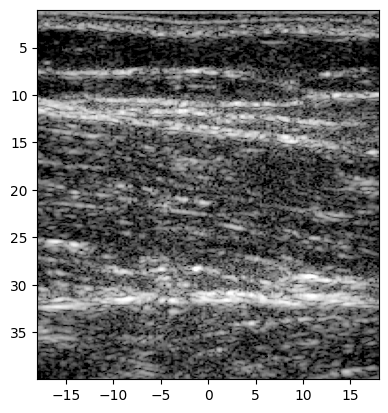

In [59]:
env = np.abs(np.mean(demod_np[0], axis=0))
logged = 20 * np.log10(env/np.percentile(env, 99))

extent = 1E3 * np.array([xout[0], xout[-1], zout[-1], zout[0]])

plt.figure()
plt.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=extent)
plt.show()

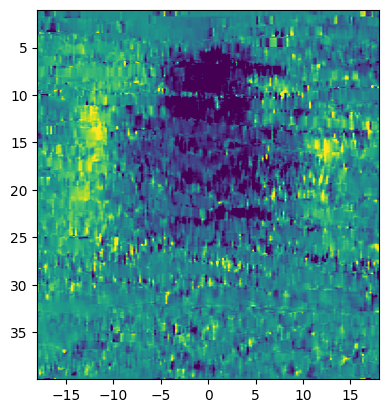

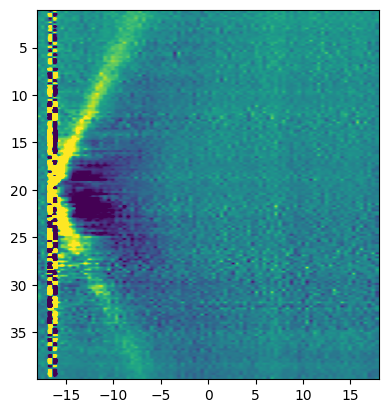

In [61]:
plt.figure()
plt.imshow(pmout[20], vmin=-3, vmax=3, cmap='viridis', extent=extent)
plt.show()

ex_tlat = np.array([t[0], t[-1], xout[-1], xout[0]])
iaxmin = pmout.shape[1]//2 - 24
iaxmax = pmout.shape[1]//2 + 24
plt.figure()
plt.imshow(np.mean(pmout[:,iaxmin:iaxmax], axis=1).T, vmin=-3, vmax=3, cmap='viridis', extent=extent)
plt.show()